In [1]:
import numpy as np

import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_gp(samples, X, palette_fill, palette_samples, fill_alpha=0.8, samples_alpha=0.1):
    """Function stolen and adapted from PyMC3
    """
    cmap_fill = plt.get_cmap(palette_fill)
    cmap_samples = plt.get_cmap(palette_samples)
    
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T
    X = X.flatten()
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100 - p, axis=1)
        color_val = colors[i]
        ax.fill_between(
            X, 
            upper, 
            lower, 
            color=cmap_fill(color_val), 
            alpha=fill_alpha
        )

    # plot a few samples
    idx = np.random.randint(0, samples.shape[1], 30)
    ax.plot(X, samples[:, idx], color=cmap_samples(0.9), lw=1, alpha=samples_alpha)

    return ax

def build_and_sample(
    X, 
    y, 
    epochs=30000, 
    length_kwargs={"alpha": 2, "beta": 1},
    eta_kwargs={"beta": 1},
    sigma_kwargs={"beta": 5},
    nu_kwargs={"alpha": 2, "beta": 0.1},
):
    """Build a model and sample from it.
    """
    with pm.Model() as model:
        
        length = pm.Gamma("length", **length_kwargs)
        eta = pm.HalfCauchy("eta", **eta_kwargs)

        cov = eta ** 2 * pm.gp.cov.Matern52(1, length)
        gp = pm.gp.Latent(cov_func=cov)

        f = gp.prior("f", X=X)

        sigma = pm.HalfCauchy("sigma", **sigma_kwargs)
        nu = pm.Gamma("nu", **nu_kwargs)
        y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

        approx = pm.fit(epochs)
        trace = approx.sample(1000)
    
    return gp, model, trace

In [3]:
df = pd.read_csv("time.csv")
df = df.rename(
    {
        "Date": "date",
        "Time": "y"
    },
    axis=1
)
df["date"] = pd.to_datetime(df["date"])
df = df[-120:]
df["y"] = (df["y"] - df["y"].mean()) / df["y"].std()

In [4]:
data_for_plotting = {
    
}
chunk_size=30
X_cond = np.arange(len(df))[:, None]

for i in range(1, 5):
    
    X = np.arange(i * chunk_size)[:, None]
    y = df["y"].values[: i * chunk_size]
    
    gp, model, trace = build_and_sample(X, y, epochs=30000)
    
    with model:
        f_pred = gp.conditional("f_pred", X_cond)
        posterior_f = pm.fast_sample_posterior_predictive(trace, var_names=["f_pred"])
        
    data_for_plotting[i - 1] = {
        "X": X.flatten(),
        "y": y.flatten(),
        "X_cond": X_cond.flatten(),
        "posterior_f": posterior_f
        
    }

Finished [100%]: Average Loss = 46.402


Finished [100%]: Average Loss = 88.013


Finished [100%]: Average Loss = 117.88


Finished [100%]: Average Loss = 146.17


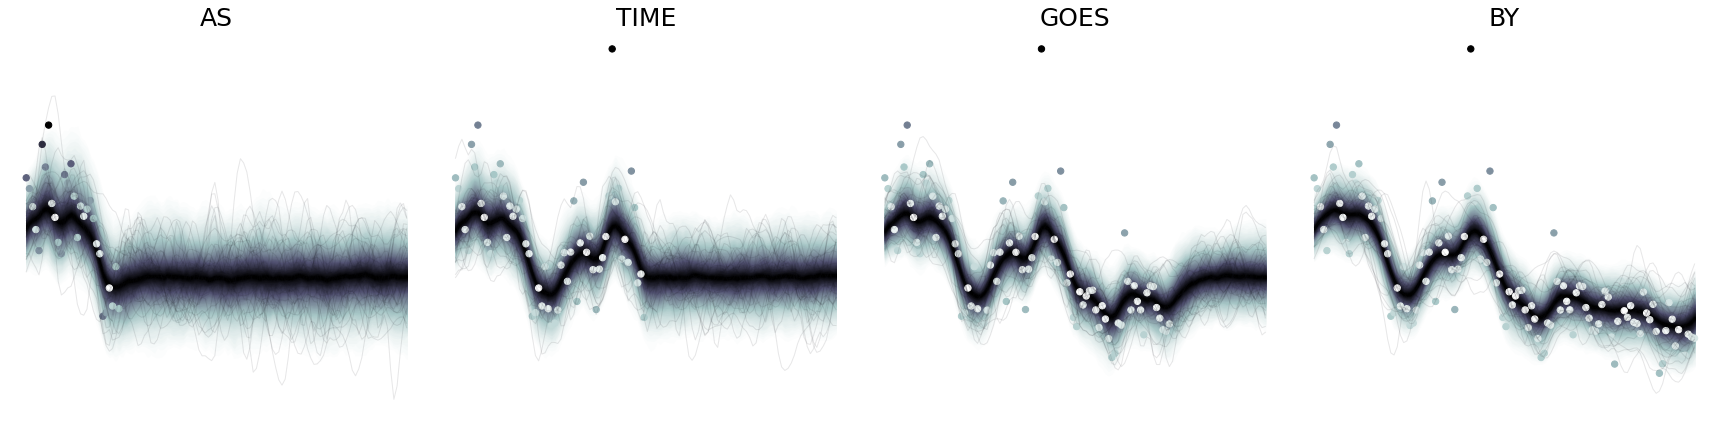

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
for index, (ax, title) in enumerate(zip(axs.flatten(), ["AS", "TIME", "GOES", "BY"])):
    
    ax = plot_gp(
        samples=data_for_plotting[index]["posterior_f"]["f_pred"], 
        X=data_for_plotting[index]["X_cond"], 
        palette_fill="bone_r", 
        palette_samples="bone_r",
        fill_alpha=0.8, 
        samples_alpha=0.1
    )
    
    scatter_c = data_for_plotting[index]["posterior_f"]["f_pred"].mean(0)[:len(data_for_plotting[index]["X"])]
    scatter_c = abs(scatter_c - data_for_plotting[index]["y"])
    ax.scatter(
        data_for_plotting[index]["X"],
        data_for_plotting[index]["y"],
        s=40,
        c=scatter_c,
        cmap="bone_r"
                                   
    )
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': 25})

plt.tight_layout()
plt.savefig("astime.png", facecolor="white", dpi=300)
plt.show()